In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
tf.keras.backend.clear_session()

### dataset information

In [109]:
from datetime import datetime
dataset = 'fmnist'
dims = (28,28,1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 128
labels_per_class = 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
print(datestring)

2020_07_28_20_23_30_436154


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_FMNIST, mask_labels

In [8]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_FMNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [9]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_labeled = Y_train
    Y_masked = np.ones(len(Y_train))
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [10]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [11]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [12]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [13]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [102]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

1000


In [15]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [16]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [17]:
encoder = tf.keras.Sequential()

encoder.add(tf.keras.layers.InputLayer(input_shape=dims))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), padding='same', activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.1))

# Conv + Maxpooling
encoder.add(tf.keras.layers.Convolution2D(64, (4, 4), activation='relu'))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.3))

# Converting 3D feature to 1D feature Vektor
encoder.add(tf.keras.layers.Flatten())

# Fully Connected Layer
encoder.add(tf.keras.layers.Dense(256, activation='relu'))

# Dropout
encoder.add(tf.keras.layers.Dropout(0.5))

In [18]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=256))
# Normalization
classifier.add(tf.keras.layers.Dense(64, activation='relu'))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [19]:
embedder = tf.keras.Sequential()
embedder.add(tf.keras.Input(shape=(256)))
embedder.add(tf.keras.layers.Dense(units=64, activation="relu"))
embedder.add(tf.keras.layers.Dense(PROJECTION_DIMS, activation=None, name='z'))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
tf.keras.backend.clear_session()
tf.compat.v1.global_variables_initializer()
tf.compat.v1.reset_default_graph()

In [115]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    embedder=embedder,
    classifier=classifier,
    umap_prop=umap_prop
    
)

TypeError: super(type, obj): obj must be an instance or subtype of type

### plotting results

In [24]:
from tfumap.semisupervised_plotting import plot_umap_classif_results, plot_results, get_decision_contour

No objects to concatenate


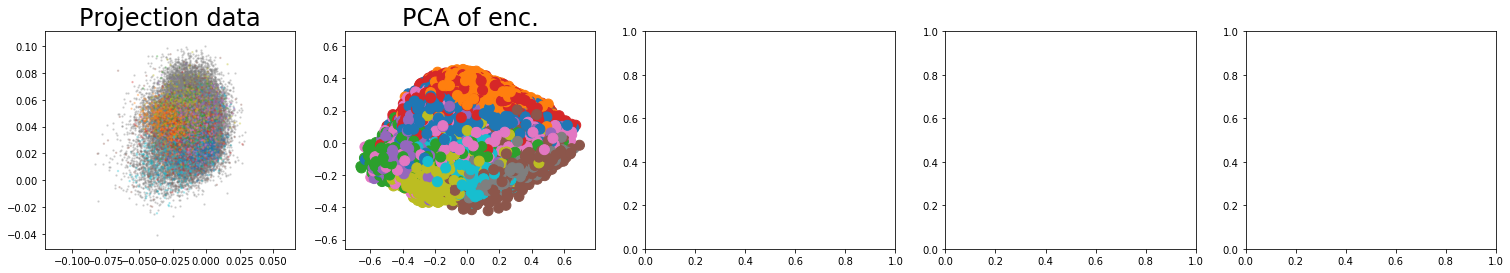

In [25]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, cmap='tab10', cmap2='tab10')

### Train model

In [26]:
batch = 0; epoch = 0
N_EPOCHS = 10
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

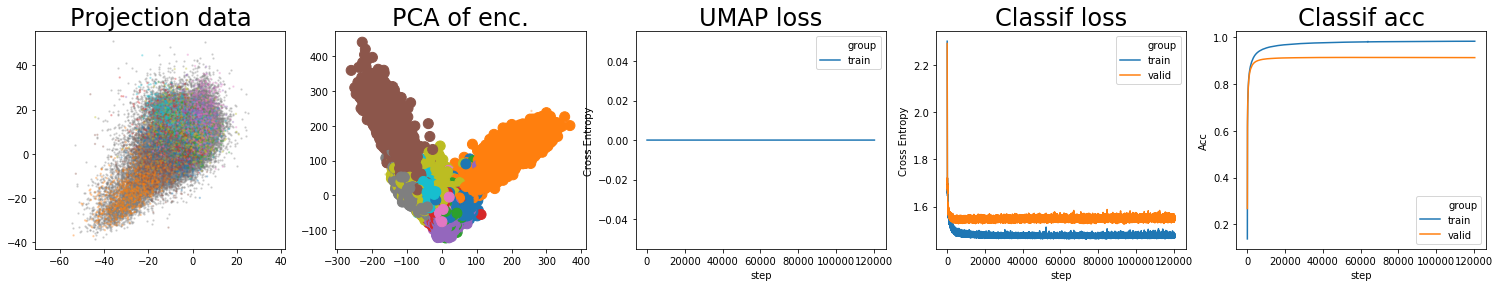

train acc: 0.9821 | val acc: 0.9121


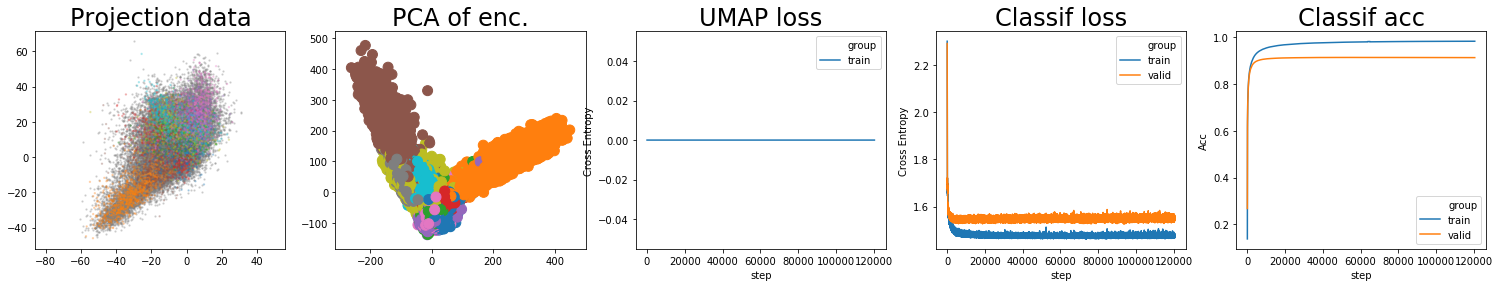

train acc: 0.9821 | val acc: 0.9121


KeyboardInterrupt: 

In [97]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )

        if batch % 1000 == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "train acc: {} | val acc: {}".format(
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
        batch += 1

In [30]:
classifier_acc, classifier_loss

(<tf.Tensor: shape=(), dtype=float32, numpy=0.9820782>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.4771502>)

In [31]:
val_acc, val_loss

(<tf.Tensor: shape=(), dtype=float32, numpy=0.9121581>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.5409766>)

In [32]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

from tfumap.semisupervised_plotting import embed_data

loss_df = retrieve_tensors(model.tensorboard_logdir)
loss_df['step'] +=1
loss_df

,wall_time,step,val,group,variable
0,1.595962e+09,1,0.138000,train,classif_acc
1,1.595962e+09,2,0.191500,train,classif_acc
2,1.595962e+09,3,0.224667,train,classif_acc
3,1.595962e+09,4,0.278500,train,classif_acc
4,1.595962e+09,5,0.304400,train,classif_acc
...,...,...,...,...,...
120425,1.595967e+09,120426,1.548151,valid,classif_loss
120426,1.595967e+09,120427,1.552950,valid,classif_loss
120427,1.595967e+09,120428,1.543146,valid,classif_loss
120428,1.595967e+09,120429,1.552446,valid,classif_loss


In [37]:
valid_acc = loss_df[
    (loss_df.group.values == "valid") & (loss_df.variable.values == "classif_acc")
].val.values

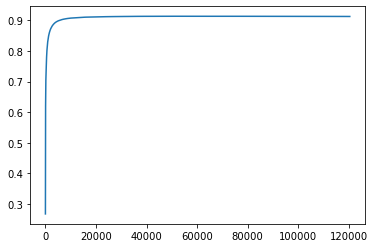

In [38]:
plt.plot(valid_acc)

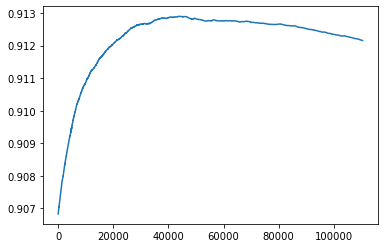

In [47]:
plt.plot(valid_acc[10000:])

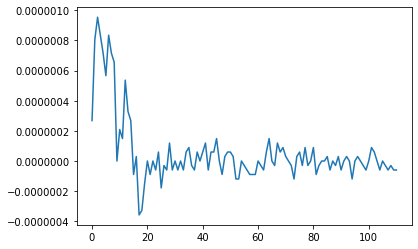

In [46]:
plt.plot(np.gradient(valid_acc)[10000:][::1000])

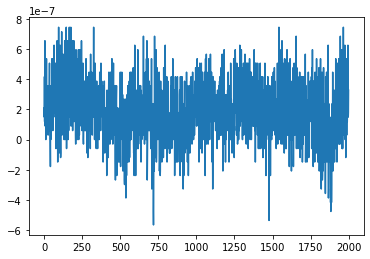

In [42]:
plt.plot(np.gradient(valid_acc)[20000:22000])

In [ ]:
# if accuracy on validation is no longer incrasing by at least min_delta, for the past patience batches, stop training

In [ ]:
patience = 0
min_delta = 0

https://stackoverflow.com/questions/43906048/which-parameters-should-be-used-for-early-stopping

after check_interval batches
save model
save train acc, val acc
if loss does not go down by more than min_delta, end

In [95]:
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement
for batch in range(len(valid_acc)):
    val_acc = valid_acc[batch]
    if val_acc > best_acc + min_delta:
        last_improvement = 0
        best_acc = val_acc
    else:
        if last_improvement>= patience:
            break
        else:
            last_improvement+=1
print(batch)

63653


(0.91, 0.914)

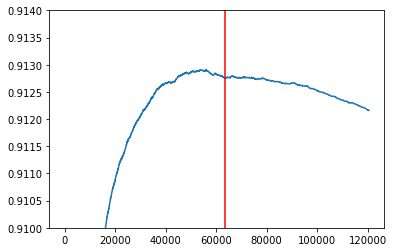

In [96]:
fig, ax = plt.subplots()
ax.plot(valid_acc)
ax.axvline(batch, color='red')
ax.set_ylim([.91, .914])

In [111]:
# early stopping parameters
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
last_improvement = 0 # delta between current batch, and the last batch that was an improvement

In [112]:
plot_frequency = 25000
save_frequency = 2500

In [116]:
from tfumap.paths import MODEL_DIR

In [113]:
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring / str(batch)

In [114]:
model.save(cpt_path)

W0728 20:27:49.846436 140598198781760 save_impl.py:83] Skipping full serialization of Keras model <tfumap.semisupervised_model.PUMAP object at 0x7fdea0767400>, because its inputs are not defined.


ValueError: Model <tfumap.semisupervised_model.PUMAP object at 0x7fdea0767400> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling .fit() or .predict(). To manually set the shapes, call model._set_inputs(inputs).

In [ ]:
for edge_epoch, epoch in tqdm(zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS):
    for (batch_to, batch_from), (X, y), (X_val, y_val) in tqdm(
        zip(edge_epoch, labeled_iter, data_valid), total=BATCHES_PER_EPOCH, leave=False
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[batch_to], batch_from=X_train[batch_from], X=X, y=y
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )
        
        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "train acc: {} | val acc: {}".format(
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )
            
        #early stopping
        if val_acc > best_acc + min_delta:
            last_improvement = 0
            best_acc = val_acc
        else:
            if last_improvement>= patience:
                break
            else:
                last_improvement+=1
            
        # save network
        
        
        batch += 1

In [ ]:
max_reinitialize_delta = .1

In [ ]:
# save every n batches
# if accuracy goes down from best accuracy by more than max_reinitialize_delta, reload lasta saved weights